### **Download and extract Food 101 Dataset**

In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [2]:
print(tf.__version__)

1.13.1


In [3]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [4]:
os.listdir('food-101/images')

['deviled_eggs',
 'caesar_salad',
 'lasagna',
 'tuna_tartare',
 'chicken_curry',
 'beef_carpaccio',
 'ceviche',
 'hot_and_sour_soup',
 'steak',
 'shrimp_and_grits',
 'risotto',
 'spaghetti_bolognese',
 'guacamole',
 'french_fries',
 'beignets',
 'macaroni_and_cheese',
 'nachos',
 'grilled_salmon',
 'french_toast',
 'fried_rice',
 'fish_and_chips',
 'hummus',
 'donuts',
 'ramen',
 'tacos',
 'chocolate_mousse',
 'falafel',
 'prime_rib',
 'lobster_roll_sandwich',
 'peking_duck',
 'beef_tartare',
 'foie_gras',
 'sashimi',
 'waffles',
 'lobster_bisque',
 'grilled_cheese_sandwich',
 'fried_calamari',
 'crab_cakes',
 'clam_chowder',
 'pancakes',
 'oysters',
 'bread_pudding',
 'chocolate_cake',
 'carrot_cake',
 'club_sandwich',
 'eggs_benedict',
 'ice_cream',
 'apple_pie',
 'beet_salad',
 'baklava',
 'garlic_bread',
 'frozen_yogurt',
 'onion_rings',
 'omelette',
 'greek_salad',
 'seaweed_salad',
 'samosa',
 'cup_cakes',
 'breakfast_burrito',
 'tiramisu',
 'pork_chop',
 'cannoli',
 'red_velvet_

In [5]:
os.listdir('food-101/meta')

['train.json',
 'test.json',
 'train.txt',
 'test.txt',
 'classes.txt',
 'labels.txt']

In [6]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [7]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

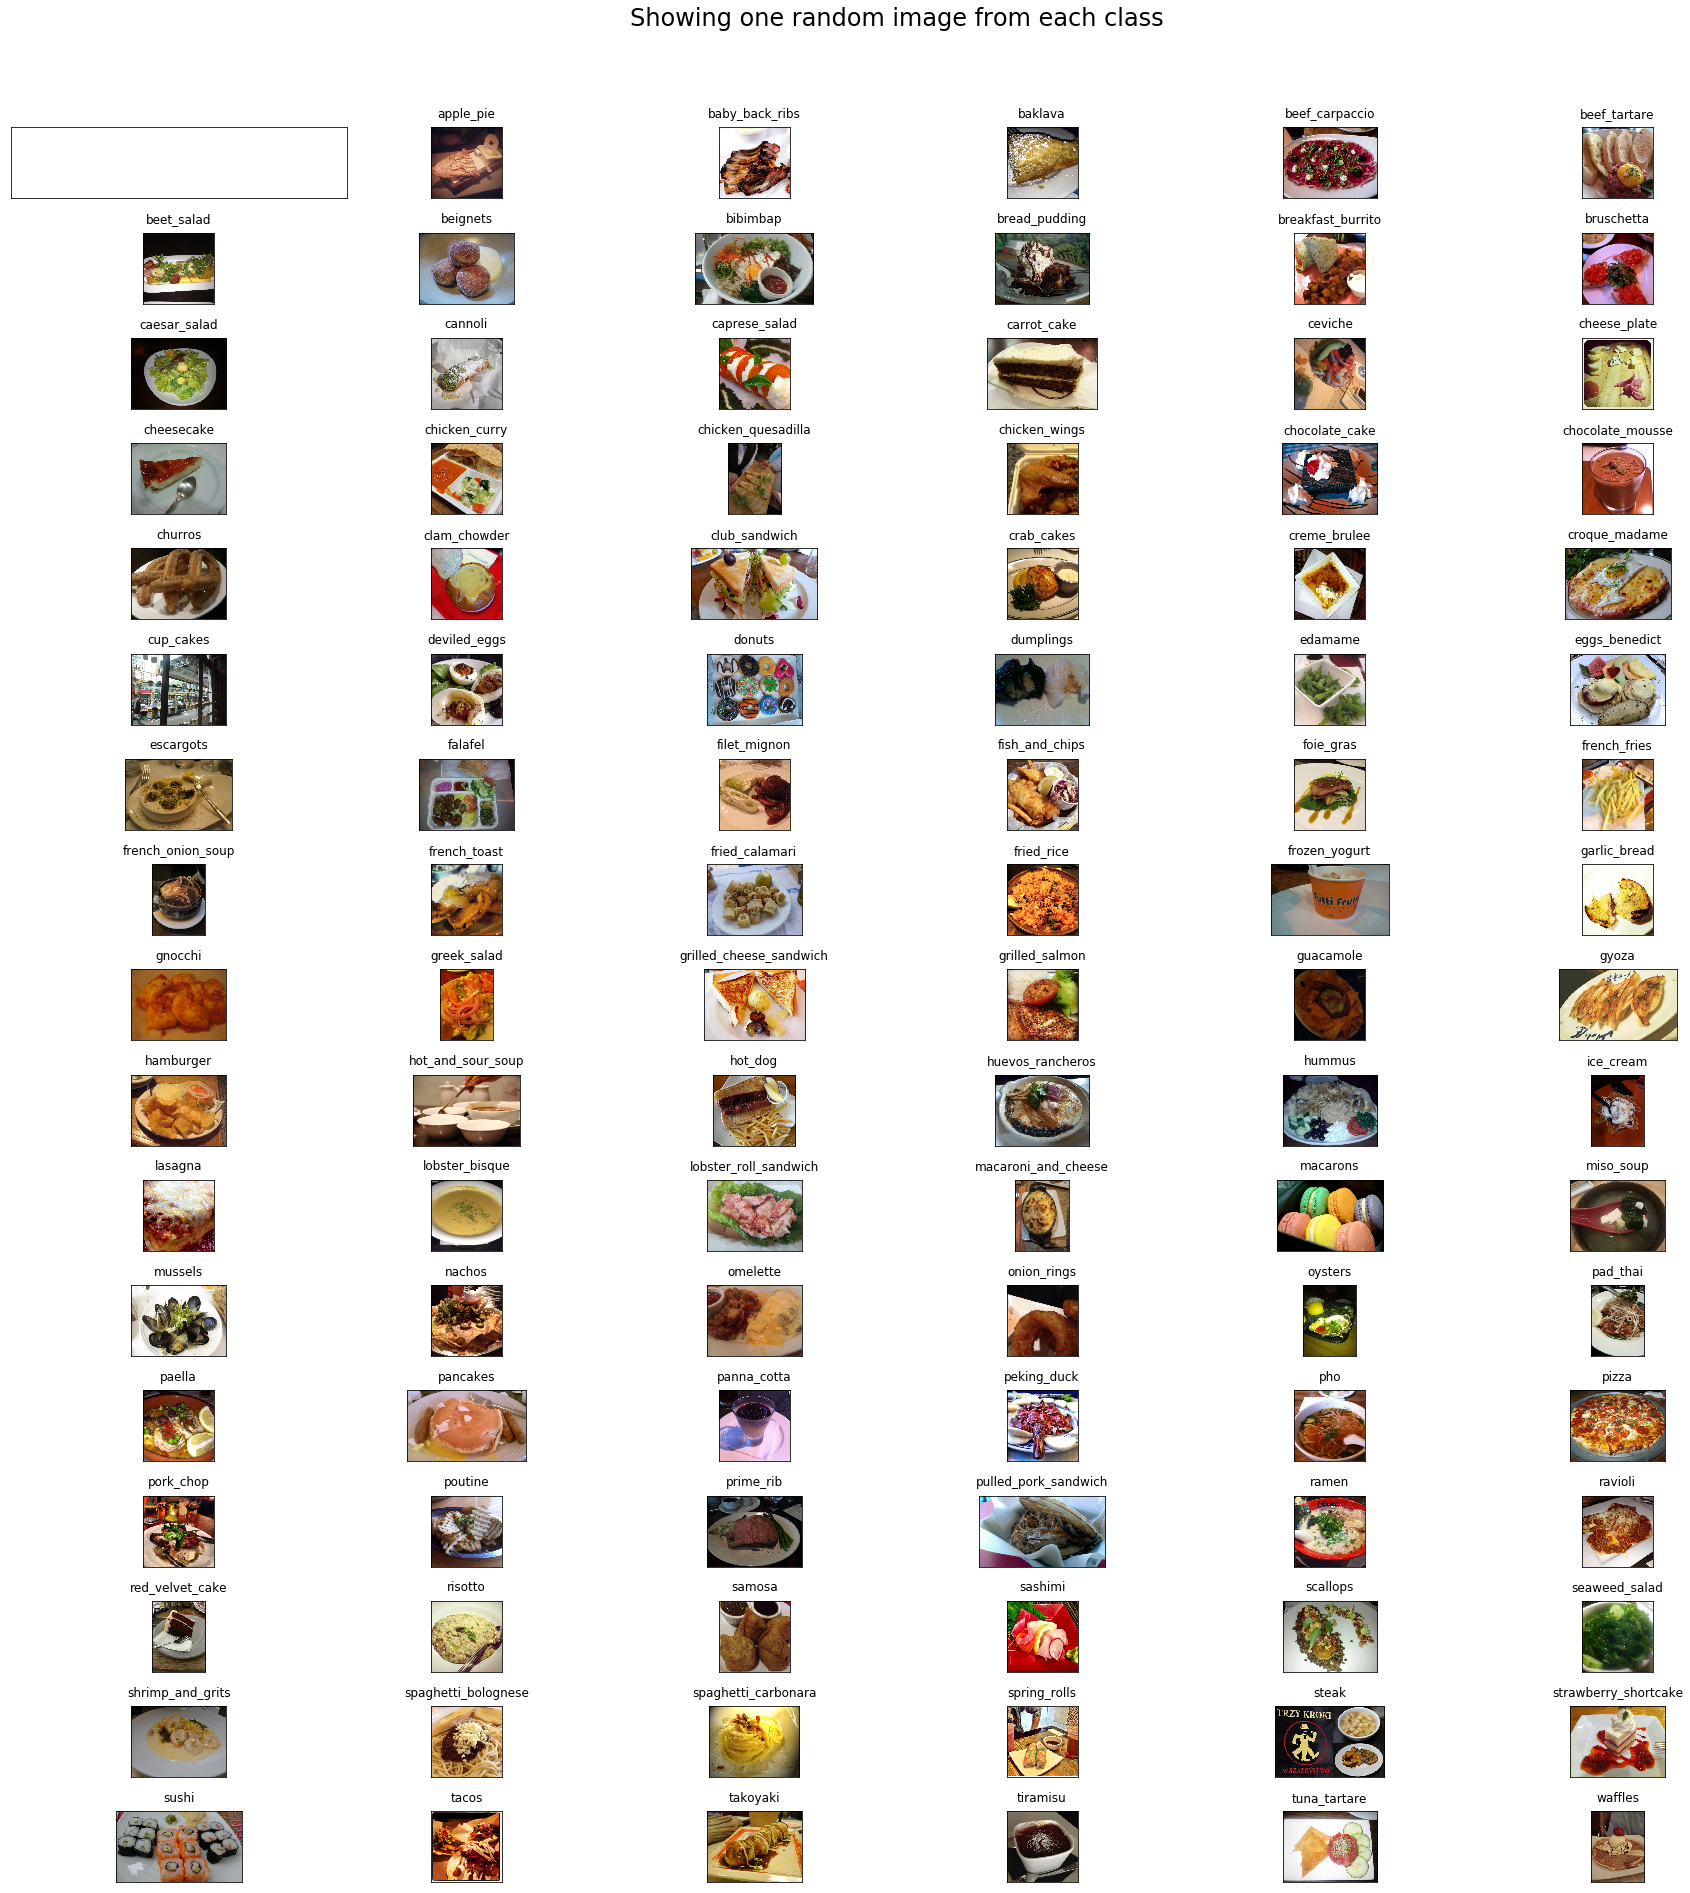

In [8]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) 
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) 
    food_selected_random = np.random.choice(food_selected_images) 
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()


### **Split the image data into train and test using train.txt and test.txt**

In [9]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [10]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [11]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [12]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [13]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


### **Create a subset of data with few classes(3)

In [14]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [15]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [16]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [17]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [18]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [19]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [20]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [21]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### **Fine tune Inception Pretrained model using Food 101 dataset**

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [22]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
47/47 [==============================] - 8s 172ms/step - loss: 0.8740 - acc: 0.6973

Epoch 00001: val_loss improved from inf to 0.87398, saving model to best_model_3class.hdf5
141/141 [==============================] - 104s 737ms/step - loss: 1.0471 - acc: 0.4813 - val_loss: 0.8740 - val_acc: 0.6973
Epoch 2/30
47/47 [==============================] - 7s 144ms/step - loss: 0.6731 - acc: 0.8173

Epoch 00002: val_loss improved from 0.87398 to 0.67309, saving model to best_model_3class.hdf5
141/141 [==============================] - 59s 420ms/step - loss: 0.8489 - acc: 0.6778 - val_loss: 0.6731 - val_ac

47/47 [==============================] - 7s 140ms/step - loss: 0.1697 - acc: 0.9560

Epoch 00023: val_loss improved from 0.17176 to 0.16968, saving model to best_model_3class.hdf5
141/141 [==============================] - 59s 418ms/step - loss: 0.1653 - acc: 0.9556 - val_loss: 0.1697 - val_acc: 0.9560
Epoch 24/30
47/47 [==============================] - 7s 143ms/step - loss: 0.1670 - acc: 0.9573

Epoch 00024: val_loss improved from 0.16968 to 0.16699, saving model to best_model_3class.hdf5
141/141 [==============================] - 58s 412ms/step - loss: 0.1533 - acc: 0.9587 - val_loss: 0.1670 - val_acc: 0.9573
Epoch 25/30
47/47 [==============================] - 7s 141ms/step - loss: 0.1671 - acc: 0.9573

Epoch 00025: val_loss did not improve from 0.16699
141/141 [==============================] - 58s 413ms/step - loss: 0.1390 - acc: 0.9640 - val_loss: 0.1671 - val_acc: 0.9573
Epoch 26/30
47/47 [==============================] - 7s 142ms/step - loss: 0.1708 - acc: 0.9547

Epoch 00026

In [23]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}